# Initial plan for training an SAE on spikes and trying to find interpretable SAE features

- [x] Get neural + behavioral data
  - [x] Get Allen visual coding neuropixels spikes data
  - [x] Get Allen visual stim data + metadata
- Train SAEs 
  - [x] Break spikes down into time windows
  - [x] Train SAEs on all spikes for a particular region for all sessions for one animal
  - Hyperparameter sweeps: 
    - Time window size
    - Number of SAE features
    - L1_coeff values
    - Try folding decoder weight norm into loss: https://transformer-circuits.pub/2024/april-update/index.html#training-saes
    - Try non-L1-loss methods to encourage SAE sparsity
      - tanh penalty https://transformer-circuits.pub/2024/feb-update/index.html#dict-learning-tanh
      - topk saes https://cdn.openai.com/papers/sparse-autoencoders.pdf
    - Add a seq_len of time windows
    - Second layer to decoder (to capture nonlinear features)
    - Different optimizers
    - Different sparsity penalties / loss functions
- Repeat this training but for particular regions for multiple animals
- [x] Interpret SAE features
  - [x] After training, feed in spikes for particular time window(s) and see which SAE feature(s) fire, and see if they correspond to the visual stim
- Validate SAEs
  - [x] Visualize reconstructions
  - [x] Validate reconstructions (e.g. cosine similarity between reconstructions and true spikes)
  - Validate sparsity (% active features over % time active)


In [1]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

In [2]:
"""Import packages."""

from dataclasses import dataclass
from IPython.display import Image
from pathlib import Path
from typing import Callable, List, Optional, Tuple, Union

import einops
import jax
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import torch
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from rich import print as rprint
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from torch import Tensor, nn, bfloat16
from torch.nn import functional as F
from tqdm.notebook import tqdm

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

## Get Allen visual coding neuropixels data

In [3]:
"""Set paths."""

out_dir = Path(r"C:\Users\jai\mini\data")
out_dir.mkdir(exist_ok=True)
print(f"{out_dir.exists()=}")

manifest_path = out_dir / "manifest.json"
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

out_dir.exists()=True


In [4]:
"""Get metadata."""

units = cache.get_units()
probes = cache.get_probes()
channels = cache.get_channels()
sessions = cache.get_session_table()

In [5]:
display(sessions.head(10))

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"
739448407,2019-10-03T00:00:00Z,716813543,brain_observatory_1.1,112.0,M,wt/wt,625,2221,6,"[grey, VISam, nan, VIS, VISp, VISl, VISrl]"
742951821,2019-10-03T00:00:00Z,723627604,brain_observatory_1.1,120.0,M,wt/wt,893,2219,6,"[VISal, nan, grey, VISl, VISrl, VISp, VISpm, VIS]"
743475441,2019-10-03T00:00:00Z,722882755,brain_observatory_1.1,121.0,M,wt/wt,553,2225,6,"[LP, LGd, HPF, DG, CA3, CA1, VISrl, nan, PP, P..."
744228101,2019-10-03T00:00:00Z,719817805,brain_observatory_1.1,122.0,M,wt/wt,659,2226,6,"[Eth, TH, LP, POL, APN, DG, CA1, VIS, nan, CA3..."


In [5]:
"""Look for animals with multiple sessions."""

bo_df = sessions[sessions["session_type"] == "brain_observatory_1.1"]  # brain observatory data
id_counts = bo_df['specimen_id'].value_counts()
repeated_ids = id_counts[id_counts > 1]
print(f"{repeated_ids=}")

repeated_ids=Series([], Name: specimen_id, dtype: int64)


No animals with more than one session, so we'll just train on single animal-session for now.

In [5]:
"""Choose a session and load in the data."""

# session = sessions[sessions["specimen_id"] == 742951821]
# session = sessions[sessions["specimen_id"] == 750332458]
session = sessions[sessions["specimen_id"] == 717038288]
display(session)
session_id = session.index.values[0]
print(f"{session_id=}")
session_data = cache.get_session_data(session_id)

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"


session_id=732592105


c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


some useful (not exhaustive) `session_data` attributes and methods

- attributes:
  - metadata
  - channels
  - stimulus_conditions
  - stimulus_presentations
  - spike_times
  - spike_amplitudes

- methods:
  - channel_structure_intervals
  - conditionwise_spike_statistics
  - get_pupil_data 
  - get_stimulus_epochs
  - get_stimulus_parameter_values
  - get_stimulus_table
  - get_lfp
  - get_screen_graze_data
  - get_invalid_times
  - presentationwise_spike_times
  - presentationwise_spike_counts
  - running_speed

In [ ]:
"""View sesssion metadata."""

display(session_data.metadata)

In [6]:
"""Choose a region to select units from, within session, and view probe metadata."""

region = "VISp"

session_channels = session_data.channels.drop(columns=["filtering"])
session_channels_visp = session_channels[session_channels["structure_acronym"] == region]

display(session_channels_visp)

,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,,,,,,,,
850231405,307,27,733744649,3080,VISp,385.0,VISp,NaN,NaN,NaN
850231359,284,43,733744649,2860,VISp,385.0,VISp,NaN,NaN,NaN
850231385,297,11,733744649,2980,VISp,385.0,VISp,NaN,NaN,NaN
850231343,276,43,733744649,2780,VISp,385.0,VISp,NaN,NaN,NaN
850231389,299,27,733744649,3000,VISp,385.0,VISp,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
850231349,279,27,733744649,2800,VISp,385.0,VISp,NaN,NaN,NaN
850231323,266,59,733744649,2680,VISp,385.0,VISp,NaN,NaN,NaN
850231281,245,11,733744649,2460,VISp,385.0,VISp,NaN,NaN,NaN


In [8]:
"""View units metadata."""

units_df = session_data.units
region_units = units_df[units_df["structure_acronym"] == region]
display(region_units)

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
915960297,0.410785,117.866385,0.001235,335,214.70,3.013238,3.051031,0.089814,50.575739,0.006127,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
915960294,0.210040,106.159365,0.000761,334,159.52,3.250551,13.198225,0.006399,74.417854,0.002733,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
915960290,0.248721,131.387490,0.053858,333,491.48,2.292449,5.642346,0.038768,58.246321,0.008143,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
915960287,0.560337,153.604815,0.034125,332,309.50,3.832008,14.034699,0.005457,67.692919,0.012434,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
915960283,0.401756,141.322935,0.046545,331,144.15,2.651925,4.370163,0.062538,49.513412,0.009947,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915960975,0.374368,262.344420,0.002301,542,85.86,5.000994,0.543841,0.269217,59.157642,0.000969,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
915960972,0.487083,126.358635,0.027390,541,358.85,3.163878,0.980188,0.290065,47.377000,0.006576,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True
915960968,0.372298,345.604740,0.001666,539,176.93,8.156430,0.634339,0.000000,95.795791,0.000010,...,385.0,VISp,NaN,NaN,NaN,probeC,See electrode locations,29999.991665,1249.999653,True


In [9]:
"""Get spikes for units within specified region."""

spike_times = session_data.spike_times
region_unit_ids = set(region_units.index)
region_spike_times = {
    unit_id: spikes
    for unit_id, spikes in spike_times.items()
    if unit_id in region_unit_ids
}
display(region_spike_times)

{915960921: array([  82.15947037,   82.20857039,   83.81880417, ..., 9414.41789664,
        9414.51213   , 9414.63093003]),
 915960683: array([7.43947753e-01, 7.61647758e-01, 1.01491450e+00, ...,
        9.41484863e+03, 9.41497826e+03, 9.41499916e+03]),
 915960678: array([6.36547724e-01, 7.61414425e-01, 8.23247775e-01, ...,
        9.41474240e+03, 9.41482016e+03, 9.41499213e+03]),
 915960674: array([1.77788137e+00, 2.66708162e+00, 2.80251499e+00, ...,
        9.41284170e+03, 9.41297856e+03, 9.41406206e+03]),
 915960812: array([3.83351528e+00, 3.95428198e+00, 7.57101632e+00, ...,
        9.41401743e+03, 9.41470813e+03, 9.41477036e+03]),
 915960810: array([5.40881030e-01, 7.20304955e+00, 7.32741625e+00, ...,
        9.36201422e+03, 9.39398782e+03, 9.40106503e+03]),
 915960586: array([6.35847723e-01, 7.76647762e-01, 8.40514447e-01, ...,
        9.17326470e+03, 9.17328940e+03, 9.17335493e+03]),
 915960835: array([6.30918263e+00, 2.68179550e+01, 2.69210884e+01, ...,
        9.41119550e+03, 

In [10]:
"""See total number of spikes, and the maximum number of spikes in a single unit."""

region_unit_spike_counts = {len(ts) for ts in region_spike_times.values()}
sum(region_unit_spike_counts), max(region_unit_spike_counts)

(6910581, 458062)

Options for feeding in spikes:
- Total spike counts per unit in a small time window

In [11]:
"""Format spikes data for SAE: binned spike counts."""

win = 0.1  # 100 ms
min_max_pairs = [(ts_arr.min(), ts_arr.max()) for ts_arr in region_spike_times.values()]
first_spike_ts, last_spike_ts = (
    min(pair[0] for pair in min_max_pairs), max(pair[1] for pair in min_max_pairs)
)
stop_time = session_data.stimulus_presentations.iloc[-1]["stop_time"]

all_spike_ts = np.concatenate(list(region_spike_times.values()))
unit_indices = np.concatenate(
    [np.full(len(spikes), i) for i, spikes in enumerate(region_spike_times.values())]
)
bins = np.arange(0, last_spike_ts, win)
counts, _, _ = np.histogram2d(
    all_spike_ts, unit_indices, bins=[bins, range(len(region_spike_times) + 1)]
)
counts = torch.from_numpy(counts.astype(np.uint8))

c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\jai\mambaforge\envs\mini\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [12]:
"""Check sparsity of binned spike counts."""

frac_nonzero_bins = torch.sum(counts > 0) / counts.numel()
spike_counts_per_bin = torch.sum(counts > 0, axis=1)
frac_nonzero_examples = sum(spike_counts_per_bin > 0) / spike_counts_per_bin.size()[0]
print(f"{frac_nonzero_bins=}\n{frac_nonzero_examples=}")

frac_nonzero_bins=tensor(0.3095)
frac_nonzero_examples=tensor(0.9997)


In [13]:
"""Convert to sparse tensor."""

indxs = torch.nonzero(counts).t()  # get nonzero indxs in appropriate format for `sparse_coo_tensor`
vals = counts[indxs[0], indxs[1]]
counts = torch.sparse_coo_tensor(indxs, vals, torch.Size(counts.shape))
print(counts)

tensor(indices=tensor([[    5,     5,     5,  ..., 94149, 94149, 94149],
                       [    5,    10,    12,  ...,   100,   102,   104]]),
       values=tensor([1, 1, 1,  ..., 2, 2, 7]),
       size=(94150, 110), nnz=3205141, dtype=torch.uint8,
       layout=torch.sparse_coo)


In [14]:
"""View binned spike counts as df."""

counts_df = pd.DataFrame(
    counts.to_dense(),
    columns=region_spike_times.keys(),  # unit IDs as column names
    index=bins[:-1],  # bin start times as index
)
display(counts_df)

,915960921,915960683,915960678,915960674,915960812,915960810,915960586,915960835,915960832,915960825,...,915960615,915960297,915960294,915960290,915960287,915960283,915960275,915960262,915960382,915960947
0.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9414.5,1,1,0,0,0,0,0,0,0,0,...,1,0,1,0,6,1,1,0,1,0
9414.6,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,5,1,1,0,2,0
9414.7,0,2,1,0,2,0,0,0,0,0,...,3,0,1,0,9,1,0,0,0,0
9414.8,0,1,1,0,0,0,0,0,0,0,...,1,0,1,0,2,1,1,0,1,0


## Train the SAE

In [15]:
"""Check torch device."""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))

device=device(type='cuda')
NVIDIA GeForce RTX 3090


In [2]:
"""Estimate gb required for largest tensor op."""

# batch_sz, n_instances, n_units, seq_len, n_hidden_ae = 8, 2, 110, 1, 10000
# [16, 2, 110] @ [2, 110, 10000] -> [16, 2, 10000]
((16 * 2 * 110) + (2 * 110 * 1000000) + (16 * 2 * 1000000) * 2) / 1e9

0.28400352

In [17]:
"""Create SAE for taking binned spike counts."""

@dataclass
class SaeConfig:
    """Config class to set some params for SAE."""
    n_input_ae: int  # number of input units to the autoencoder
    n_hidden_ae: int = 10_000  # number of hidden units in the autoencoder
    n_instances: int = 2  # number of model instances to optimize in parallel
    l1_coeff: float = 0.0  # relative weight of sparsity_loss : activations_reconstruction_loss


class Sae(nn.Module):
    """SAE model for learning sparse representations of binned spike counts."""
    # Shapes of weights and biases for the encoder and decoder in the single-layer SAE.
    W_enc: Float[Tensor, "inst input_ae hidden_ae"]
    W_dec: Float[Tensor, "inst hidden_ae input_ae"]
    b_enc: Float[Tensor, "inst hidden_ae"]
    b_dec: Float[Tensor, "inst input_ae"]

    def __init__(self, cfg: SaeConfig):
        """Initializes model parameters."""
        super().__init__()
        self.cfg = cfg
        self.W_enc = nn.Parameter(
            nn.init.xavier_normal_(
                torch.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae), dtype=bfloat16)
            )
        )
        self.W_dec = nn.Parameter(
            nn.init.xavier_normal_(
                torch.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae), dtype=bfloat16)
            )
        )
        self.b_enc = nn.Parameter(torch.zeros((cfg.n_instances, cfg.n_hidden_ae), dtype=bfloat16))
        self.b_dec = nn.Parameter(torch.zeros((cfg.n_instances, cfg.n_input_ae), dtype=bfloat16))

    def forward(self, h: Float[Tensor, "batch inst input_ae"]):
        """Computes loss as a function of SAE feature sparsity and spike_count reconstructions."""
        # Compute encoder hidden activations.
        z = F.relu(
            einops.einsum(
                h,
                self.W_enc,
                "batch inst input_ae, inst input_ae hidden_ae -> batch inst hidden_ae",
            ) 
            + self.b_enc
        )

        # Compute reconstructed input.
        h_prime = (
            einops.einsum(
                z,
                self.W_dec,
                "batch inst hidden_ae, inst hidden_ae input_ae -> batch inst input_ae",
            ) 
            + self.b_dec
        )

        # Compute loss ( l1_loss (sparsity) and l2_loss (reconstruction) ) 
        l1_loss = einops.reduce(z.abs(), "batch inst hidden_ae -> batch inst", "sum")
        recon_actual_log_ratio = torch.log(h_prime / (h + 1e-7))
        l2_loss = einops.reduce(
            recon_actual_log_ratio.pow(2), "batch inst input_ae -> batch inst", "mean"
        )
        loss = (self.cfg.l1_coeff * l1_loss + l2_loss).mean(0).sum()  # scalar
        return l1_loss, l2_loss, loss, z, h_prime

    @torch.no_grad()
    def normalize_decoder(self) -> None:
        """Unit norms the decoder weights."""
        self.W_dec.data = self.W_dec.data / self.W_dec.data.norm(dim=2, keepdim=True)

In [18]:
"""Add method to `Sae` to resample dead neurons."""

@torch.no_grad()
def resample_neurons(
    self: Sae,
    frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
) -> Tuple[List[List[str]], str]:  # -> (colors_for_neurons, title_with_resampling_info)
    """Resamples neurons dead for `dead_neuron_window` steps, according to `frac_active`."""
    # Get a tensor of dead neurons.
    dead_features_mask = frac_active_in_window.sum(0) < 1e-8  # -> [n_instances n_hidden_ae]
    n_dead = dead_features_mask.int().sum().item()

    # Get our random replacement values (-> [n_dead n_input_ae]).
    replacement_vals = torch.randn((n_dead, self.cfg.n_input_ae), device=self.W_enc.device)
    replacement_vals_norm = replacement_vals / replacement_vals.norm(dim=-1, keepdim=True) + 1e-8

    # Reset W_enc, W_dec, and b_enc (we transpose W_enc to return a view with correct shape).
    self.W_enc.data.transpose(-1, -2)[dead_features_mask] = replacement_vals_norm
    self.W_dec.data[dead_features_mask] = replacement_vals_norm
    self.b_enc.data[dead_features_mask] = 0.0

    # Return data for visualising the resampling process.
    colors = [
        ["red" if dead else "black" for dead in dead_neuron_mask_inst]
        for dead_neuron_mask_inst in dead_features_mask
    ]
    title = f"resampling {n_dead}/{dead_features_mask.numel()} neurons (shown in red)"
    return colors, title

# Add method to sae class.
Sae.resample_neurons = resample_neurons

In [19]:
"""Add `Sae` optimization method."""

def lr_schedule(*_):
    """Simple learning rate schedule."""
    return 1.0

def optimize(
    self: Sae,
    spike_counts: Int[Tensor, "n_timebins n_units"],
    seq_len: int = 1,  # number of timebins to use in each spike_count_seq
    batch_sz: int = 16,
    steps: int = 200_000,
    log_freq: int = 1000,
    lr: float = 1e-3,
    lr_scale: Callable[[int, int], float] = lr_schedule,
    neuron_resample_window: Optional[int] = None,  # in optimization steps
):
    """Optimizes the autoencoder using the given hyperparameters."""
    optimizer = torch.optim.Adam(list(self.parameters()), lr=lr)

    # Create lists to store data we'll eventually be plotting.
    frac_active_list = []  # fraction of non-zero activations for each neuron (feature)
    data_log = {"frac_active": [], "W_enc": [], "W_dec": [], "titles": [], "colors": []}
    colors = None
    title = "No resampling"

    # Define valid samples for `spike_counts`.
    n_timebins, _n_units = spike_counts.shape
    valid_starts = n_timebins - seq_len + 1

    progress_bar = tqdm(range(steps))
    for step in progress_bar:
        # Normalize decoder weights at each step to prevent artificially small / sparse
        # features from large decoder weights.
        self.normalize_decoder()

        # Check for dead neurons, and resample them if found.
        if (neuron_resample_window is not None) and ((step + 1) % neuron_resample_window == 0):
            frac_active_in_window = torch.stack(frac_active_list[-neuron_resample_window:], dim=0)
            colors, title = self.resample_neurons(frac_active_in_window)

        # Update learning rate.
        step_lr = lr * lr_scale(step, steps)
        for group in optimizer.param_groups:
            group["lr"] = step_lr

        # Get batch of spike counts to feed into SAE.
        start_indxs = torch.randint(0, valid_starts, (self.cfg.n_instances, batch_sz))
        seq_indxs = start_indxs.unsqueeze(-1) + torch.arange(seq_len)
        spike_count_seqs = spike_counts[seq_indxs]  # -> [n_instances batch_sz seq_len n_units]
        spike_count_seqs = einops.rearrange(  # format for SAE
            spike_count_seqs,
            'n_instances batch_sz seq_len n_units -> (batch_sz seq_len) n_instances n_units'
        )

        # Optimize.
        optimizer.zero_grad()
        l1_loss, l2_loss, loss, z, _ = self.forward(spike_count_seqs)
        loss.backward()
        optimizer.step()

        # Calculate the sparsities and them to the list.
        frac_active = einops.reduce(
            (z.abs() > 1e-8).float(),
            "batch_sz n_instances hidden_ae -> n_instances hidden_ae",
            "mean",
        )
        frac_active_list.append(frac_active.detach().cpu())

        # Display progress bar, and append new values for plotting.
        if step % log_freq == 0 or (step + 1 == steps):
            progress_bar.set_postfix(
                l1_loss=self.cfg.l1_coeff * l1_loss.mean(0).sum().item(),
                l2_loss=l2_loss.mean(0).sum().item(),
                lr=step_lr,
            )
            data_log["W_enc"].append(self.W_enc.detach().cpu())
            data_log["W_dec"].append(self.W_dec.detach().cpu())
            data_log["titles"].append(f"Step {step}/{steps}: {title}")
            data_log["frac_active"].append(frac_active.detach().cpu())
            data_log["colors"].append(colors)

    return data_log

# Add method to SAE class.
Sae.optimize = optimize

In [20]:
"""Train the SAE."""

ae_cfg = SaeConfig(
    n_input_ae=counts.shape[1],
    n_instances=2,
    n_hidden_ae=10_000,
    l1_coeff=0.01,
)
sae = Sae(ae_cfg).to(device)

# spike_counts = counts.to_dense().bfloat16().to(device)
# data_log = sae.optimize(spike_counts=spike_counts, steps=50_000, batch_sz=16, lr=0.05)
# torch.save(sae.state_dict(), Path(r"C:\Users\jai\mini\trained_saes\sae0.pth"))

sae.load_state_dict(torch.load(Path(r"C:\Users\jai\mini\trained_saes\sae0.pth")))

C:\Users\jai\AppData\Local\Temp\ipykernel_30872\293224781.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae.load_state_dict(torch.load(Path(r"C:\Users\jai\mini\traine

<All keys matched successfully>

## Interpret the SAE features

### SAE features corresponding to full-field flash presentations

In [21]:
"""View visual stim metadata."""

session_stim_data = session_data.get_stimulus_table()

display(session_stim_data)
print(f"Visual stimuli types: {session_stim_data['stimulus_name'].unique()}")
n_nat_imgs = len(
    session_stim_data[session_stim_data["stimulus_name"] == "natural_scenes"]
    ["stimulus_condition_id"].unique()
)
print(f"{n_nat_imgs=}")

,stimulus_block,start_time,stop_time,phase,color,x_position,size,contrast,temporal_frequency,y_position,stimulus_name,spatial_frequency,frame,orientation,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,21.579074,81.645874,null,null,null,null,null,null,null,spontaneous,null,null,null,60.066800,0
1,0.0,81.645874,81.879397,"[3644.93333333, 3644.93333333]",null,-30.0,"[20.0, 20.0]",0.8,4.0,-20.0,gabors,0.08,null,45.0,0.233523,1
2,0.0,81.879397,82.129600,"[3644.93333333, 3644.93333333]",null,20.0,"[20.0, 20.0]",0.8,4.0,-10.0,gabors,0.08,null,90.0,0.250203,2
3,0.0,82.129600,82.379803,"[3644.93333333, 3644.93333333]",null,40.0,"[20.0, 20.0]",0.8,4.0,30.0,gabors,0.08,null,90.0,0.250203,3
4,0.0,82.379803,82.630006,"[3644.93333333, 3644.93333333]",null,40.0,"[20.0, 20.0]",0.8,4.0,-40.0,gabors,0.08,null,45.0,0.250203,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70383,14.0,9142.164805,9142.415016,0.75,null,null,"[250.0, 250.0]",0.8,null,null,static_gratings,0.04,null,60.0,0.250210,4806
70384,14.0,9142.415016,9142.665223,0.0,null,null,"[250.0, 250.0]",0.8,null,null,static_gratings,0.08,null,30.0,0.250207,4857
70385,14.0,9142.665223,9142.915430,0.75,null,null,"[250.0, 250.0]",0.8,null,null,static_gratings,0.32,null,60.0,0.250207,4876


Visual stimuli types: ['spontaneous' 'gabors' 'flashes' 'drifting_gratings'
 'natural_movie_three' 'natural_movie_one' 'static_gratings'
 'natural_scenes']
n_nat_imgs=119


In [22]:
session_stim_data[session_stim_data["stimulus_name"] == "flashes"]

,stimulus_block,start_time,stop_time,phase,color,x_position,size,contrast,temporal_frequency,y_position,stimulus_name,spatial_frequency,frame,orientation,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
3647,1.0,1282.632614,1282.882832,"[0.0, 0.0]",-1.0,null,"[300.0, 300.0]",0.8,null,null,flashes,"[0.0, 0.0]",null,0.0,0.250218,244
3648,1.0,1284.634334,1284.884540,"[0.0, 0.0]",1.0,null,"[300.0, 300.0]",0.8,null,null,flashes,"[0.0, 0.0]",null,0.0,0.250205,245
3649,1.0,1286.636014,1286.886217,"[0.0, 0.0]",1.0,null,"[300.0, 300.0]",0.8,null,null,flashes,"[0.0, 0.0]",null,0.0,0.250203,245
3650,1.0,1288.637634,1288.887855,"[0.0, 0.0]",-1.0,null,"[300.0, 300.0]",0.8,null,null,flashes,"[0.0, 0.0]",null,0.0,0.250220,244
3651,1.0,1290.639354,1290.889562,"[0.0, 0.0]",1.0,null,"[300.0, 300.0]",0.8,null,null,flashes,"[0.0, 0.0]",null,0.0,0.250208,245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3792,1.0,1572.875204,1573.125420,"[0.0, 0.0]",-1.0,null,"[300.0, 300.0]",0.8,null,null,flashes,"[0.0, 0.0]",null,0.0,0.250215,244
3793,1.0,1574.876904,1575.127112,"[0.0, 0.0]",-1.0,null,"[300.0, 300.0]",0.8,null,null,flashes,"[0.0, 0.0]",null,0.0,0.250208,244
3794,1.0,1576.878604,1577.128807,"[0.0, 0.0]",1.0,null,"[300.0, 300.0]",0.8,null,null,flashes,"[0.0, 0.0]",null,0.0,0.250203,245


In [23]:
"""Get the final few flash presentations and spike counts at these times."""

round_to = 1  # decimal places to round to (for start time of spike count bin)

flashes = session_stim_data[session_stim_data["stimulus_name"] == "flashes"].iloc[-4:]
display(flashes)

flash_times_dark = []
flash_times_light = []
for _, row in flashes.iterrows():  # get all time bins for each flash
    cur_stim_times = np.unique(np.arange(row["start_time"], row["stop_time"], win).round(round_to))
    if row["color"] < 0:
        flash_times_dark.extend(cur_stim_times)
    else:
        flash_times_light.extend(cur_stim_times)

counts_df.index = np.round(counts_df.index, round_to)
counts_flash_df = counts_df.loc[flash_times_light]
display(counts_flash_df)

,stimulus_block,start_time,stop_time,phase,color,x_position,size,contrast,temporal_frequency,y_position,stimulus_name,spatial_frequency,frame,orientation,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
3793,1.0,1574.876904,1575.127112,"[0.0, 0.0]",-1.0,null,"[300.0, 300.0]",0.8,null,null,flashes,"[0.0, 0.0]",null,0.0,0.250208,244
3794,1.0,1576.878604,1577.128807,"[0.0, 0.0]",1.0,null,"[300.0, 300.0]",0.8,null,null,flashes,"[0.0, 0.0]",null,0.0,0.250203,245
3795,1.0,1578.880274,1579.130475,"[0.0, 0.0]",1.0,null,"[300.0, 300.0]",0.8,null,null,flashes,"[0.0, 0.0]",null,0.0,0.250200,245
3796,1.0,1580.881944,1581.132147,"[0.0, 0.0]",-1.0,null,"[300.0, 300.0]",0.8,null,null,flashes,"[0.0, 0.0]",null,0.0,0.250203,244


,915960921,915960683,915960678,915960674,915960812,915960810,915960586,915960835,915960832,915960825,...,915960615,915960297,915960294,915960290,915960287,915960283,915960275,915960262,915960382,915960947
1576.9,0,0,1,0,0,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0
1577.0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
1577.1,0,0,0,0,0,0,5,0,0,0,...,2,1,2,0,0,0,0,1,0,0
1578.9,0,0,0,0,0,0,3,0,0,0,...,3,0,4,0,0,0,1,0,0,0
1579.0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0
1579.1,0,1,0,0,0,1,2,0,0,0,...,2,0,0,0,0,1,0,1,0,0


In [24]:
"""Get topk SAE features for each flash."""

k = 5
topk_feat_indxs_all = []
topk_feat_vals_all = []

# For each flash timebin, get corresponding spike count sequences and run through SAE.
for i, (_, row) in enumerate(counts_flash_df.iterrows()):
    spike_count_seqs = einops.repeat(
        torch.from_numpy(row.values).bfloat16().to(device),
        "n_units -> batch_sz n_instances n_units",
        batch_sz=1,
        n_instances=2,
    )
    _l1_loss, _l2_loss, _loss, feat_acts, recon_spk_cts = sae.forward(spike_count_seqs)
    # Quick sanity check that we get a strongly activated SAE feature,
    # and that spike count reconstructions are decent.
    print(f"flash timebin {i+1}:")
    print(f"  max feat act: {torch.max(feat_acts).item()}")
    print(f"  max recon spk ct: {torch.max(recon_spk_cts).item()}")
    print(f"  max actual spk ct: {spike_count_seqs.max().item()}\n")
    topk_feat_vals, topk_feat_idxs = feat_acts[0, 0, :].topk(k)
    topk_feat_vals_all.append(topk_feat_vals)
    topk_feat_indxs_all.append(topk_feat_idxs)

# See topk features for each flash.
display(topk_feat_indxs_all)

flash timebin 1:
  max feat act: 19.375
  max recon spk ct: 20.0
  max actual spk ct: 22.0

flash timebin 2:
  max feat act: 0.3359375
  max recon spk ct: 0.640625
  max actual spk ct: 2.0

flash timebin 3:
  max feat act: 12.5
  max recon spk ct: 15.0625
  max actual spk ct: 16.0

flash timebin 4:
  max feat act: 12.1875
  max recon spk ct: 14.0625
  max actual spk ct: 15.0

flash timebin 5:
  max feat act: 5.375
  max recon spk ct: 6.1875
  max actual spk ct: 7.0

flash timebin 6:
  max feat act: 12.4375
  max recon spk ct: 15.0
  max actual spk ct: 16.0



[tensor([8785, 5339, 4542, 6517, 4707], device='cuda:0'),
 tensor([4707,    2,    0,    3,    1], device='cuda:0'),
 tensor([8785, 6517, 2397, 5339,  484], device='cuda:0'),
 tensor([8785, 5339, 2397, 2474,  484], device='cuda:0'),
 tensor([8785, 2397, 6653, 4370, 3396], device='cuda:0'),
 tensor([8785, 6517,  484, 2474, 5339], device='cuda:0')]

Found some characteristic SAE features?! =D 

Looks like features 8785, 5339, 5417 might fire for full-field flashes!

## Validate SAEs

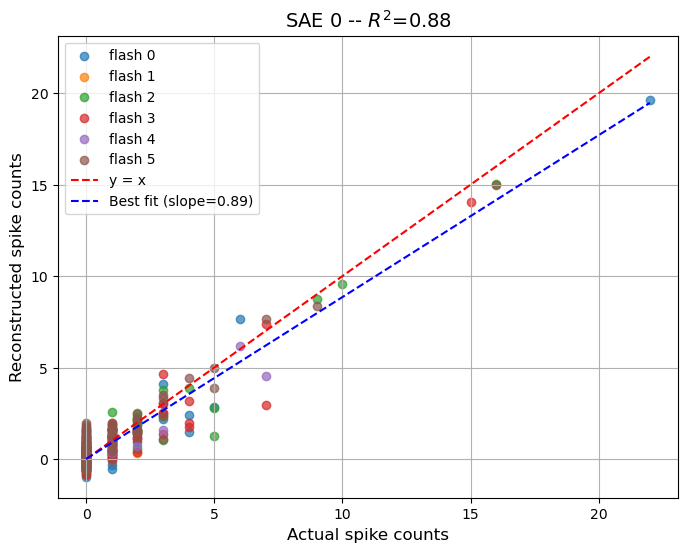

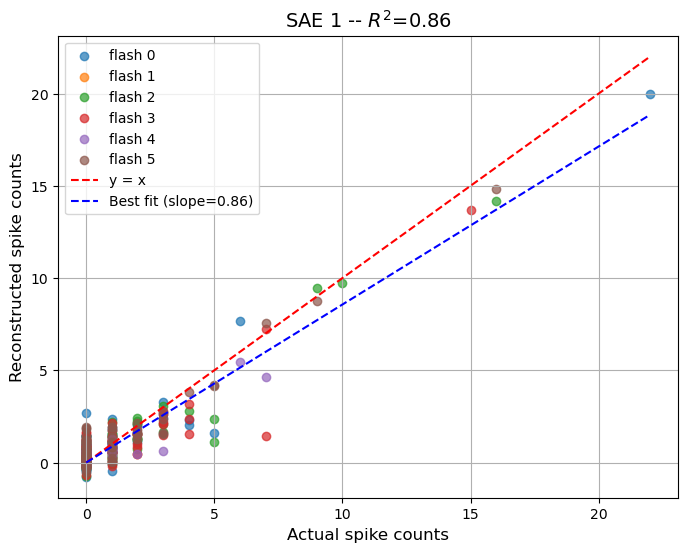

In [38]:
"""View spike counts actual vs. spike counts reconstructions for flashes for SAEs."""

def plot_reconstructed_spike_counts(sae_idx, counts_flash_df, sae_model, device) -> (
    tuple[np.ndarray, plt.Figure]
):
    # Pre-allocate numpy arrays
    n_samples, n_units = len(counts_flash_df), counts_flash_df.shape[1]
    cos_sims = np.empty(n_samples)
    all_actual = np.empty((n_samples, n_units))
    all_recon = np.empty((n_samples, n_units))
    max_ct_spks = 0

    # Initialize figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for i, (_, row) in enumerate(counts_flash_df.iterrows()):
        spike_count_seqs = einops.repeat(
            torch.from_numpy(row.values).bfloat16().to(device),
            "n_units -> batch_sz n_instances n_units",
            batch_sz=1,
            n_instances=2,
        )
        _l1_loss, _l2_loss, _loss, _feat_acts, recon_spk_cts = sae_model.forward(spike_count_seqs)
        
        actual = row.values
        recon = einops.asnumpy(recon_spk_cts[0, sae_idx, :].to(torch.float32))
        
        all_actual[i] = actual
        all_recon[i] = recon

        ax.scatter(actual, recon, label=f"flash {i}", alpha=0.7)
        max_ct_spks = max(max_ct_spks, actual.max())

        cos_sims[i] = torch.cosine_similarity(
            recon_spk_cts[0, sae_idx, :], spike_count_seqs[0, sae_idx, :], dim=0
        ).item()

    # Flatten arrays for regression and R² computation
    all_actual_flat = all_actual.ravel()
    all_recon_flat = all_recon.ravel()
    
    # Compute R² score and get line of best fit
    r2 = r2_score(all_actual_flat, all_recon_flat)
    reg = LinearRegression(fit_intercept=False)
    reg.fit(all_actual_flat.reshape(-1, 1), all_recon_flat)
    slope = reg.coef_[0]

    # Plot lines
    ax.plot([0, max_ct_spks], [0, max_ct_spks], color="red", linestyle="--", label="y = x")
    ax.plot(
        [0, max_ct_spks], 
        [0, slope*max_ct_spks], 
        color="blue",
        linestyle="--",
        label=f"Best fit (slope={slope:.2f})"
    )

    ax.set_title(f"SAE {sae_idx} -- $R^2$={r2:.2f}", fontsize=14)
    ax.set_xlabel("Actual spike counts", fontsize=12)
    ax.set_ylabel("Reconstructed spike counts", fontsize=12)
    ax.legend()
    ax.grid(True)

    return cos_sims, fig

spk_recon_cos_sims_sae0, _ = plot_reconstructed_spike_counts(0, counts_flash_df, sae, device)
spk_recon_cos_sims_sae1, _ = plot_reconstructed_spike_counts(1, counts_flash_df, sae, device)

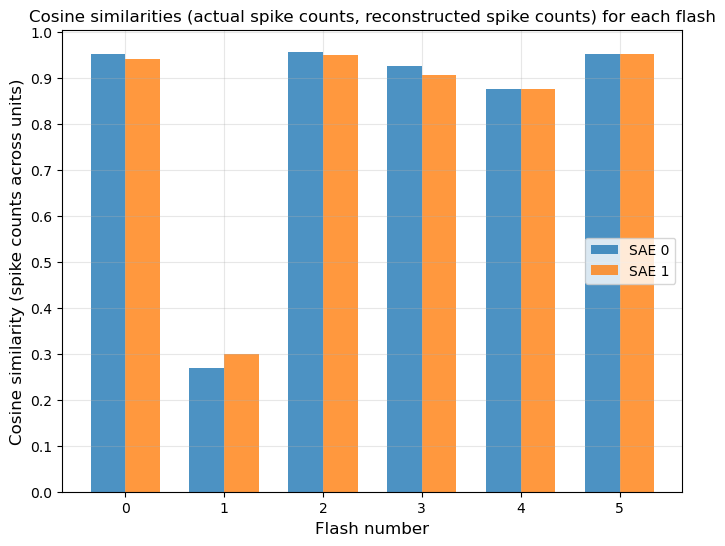

In [50]:
"""Plot cosine similarities of spikes-to-reconstructions for each flash."""

x = np.arange(len(spk_recon_cos_sims_sae0))
width = 0.35  # Width of the bars

# Initialize the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Create grouped bars
ax.bar(x - width/2, spk_recon_cos_sims_sae0, width, label="SAE 0", alpha=0.8)
ax.bar(x + width/2, spk_recon_cos_sims_sae1, width, label="SAE 1", alpha=0.8)

# Set titles and labels
ax.set_title(
    "Cosine similarities (actual spike counts, reconstructed spike counts) for each flash"
)
ax.set_xlabel("Flash number", fontsize=12)
ax.set_ylabel("Cosine similarity (spike counts across units)", fontsize=12)
ax.legend(loc="center right")
ax.grid(True, alpha=0.3)

# Set x-ticks to be centered between grouped bars
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.show()

- Find spike_counts examples within flash start and stop times
    
    - Feed those spikes into SAE and see what features fire

- Look at all times when flash-feature is active (is it active only at times of full-field flashes?)

- Get distribution of L0 (number of features active per example)

- Get % of SAE variance explained

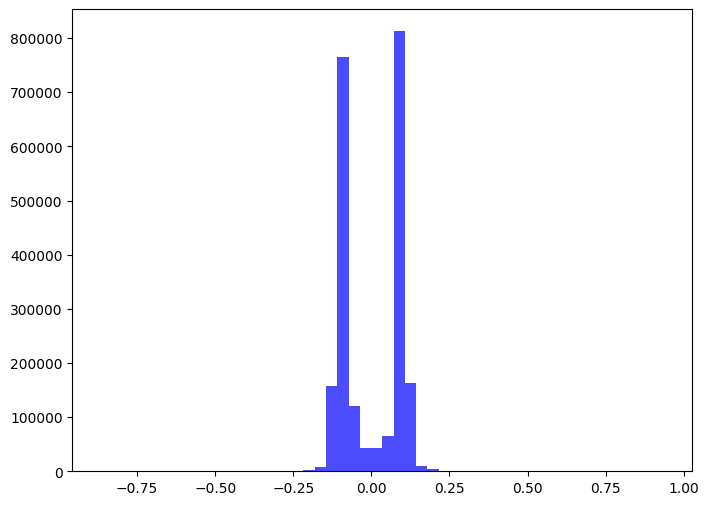

In [33]:
"""Visualize decoder weights."""

# Flatten and plot a histogram of decoder weights
W_dec_flat = sae.W_dec.to(torch.float16).detach().flatten().cpu().numpy()
plt.figure(figsize=(8, 6))
plt.hist(W_dec_flat, bins=50, color="blue", alpha=0.7)
plt.show()

## Scratchpad below here